TODO: option to save everything as SVG and CSV, and add statistics for CDFs,  add n for metrics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import seaborn as sns
from collections import namedtuple
from scipy.optimize import curve_fit
from ht2.io_handler import *

sns.set_theme("notebook", "white")

def batch_read_idealized(fpath_list):
    idl_df = []
    for i, fpath in enumerate(fpath_list):
        raw_trace = pd.read_csv(fpath, sep="\s+", index_col=False, header=None)
        raw_trace.columns = ["x", "y", "I", "t", "spots"]
        idl_trace = fpath.parent.joinpath(fpath.name[:-4] + "_idealized_traces.txt")
        idl_trace = pd.read_csv(idl_trace, sep="\s+", index_col=False, header=None)
        G = idl_trace[0]
        G[G == G.max()] = 1
        G[G == G.min()] = 0
        raw_trace["Normalized Intensity"] = raw_trace["I"] - np.percentile(raw_trace["I"], 30)
        raw_trace["Normalized Intensity"] = raw_trace["Normalized Intensity"] / np.percentile(raw_trace["Normalized Intensity"], 98)
        raw_trace["Time (min)"] = raw_trace["t"] * 100 / 60
        raw_trace["State"] = idl_trace[0]
        idl_df.append(raw_trace)
    return idl_df

def read_cond_traces(cond_path: Path):
    cpath = cond_path.joinpath("coupled")

    cg_trace_list = cpath.glob("*G_Dual*.trk")
    cg_trace_df = batch_read_idealized(cg_trace_list)
    cr_trace_list = cpath.glob("*R_Dual*.trk")
    cr_trace_df = batch_read_idealized(cr_trace_list)

    return {"G":cg_trace_df, "R":cr_trace_df}

In [2]:
parent_path = Path(r"C:\Users\Imageanalysis\Desktop\Ike\New")
path_list = sorted(parent_path.glob("*/"))
cond_names = ["Fibronectin", 
              "Laminin", 
              "Soft FN", 
              "Soft Lam", 
              "Stiff FN", 
              "Stiff Lam", 
              "20% Stretch", 
              "0% Stretch", 
              "Control", 
              "Hypotonic", 
              "Compression"]
[print(dirpath.name, " || ", cond) for dirpath, cond in zip(path_list, cond_names)]

001-1MaxIP_fn  ||  Fibronectin
001-1MaxIP_lam  ||  Laminin
003-4_soft_fn  ||  Soft FN
003-4_soft_lam  ||  Soft Lam
003-4_stiff_fn  ||  Stiff FN
003-4_stiff_lam  ||  Stiff Lam
004-4MaxIP_STRETCH_20  ||  20% Stretch
005-1MaxIP_STRETCH_0  ||  0% Stretch
009-0Cont  ||  Control
47_49HypOtonic_hyp_ctrl  ||  Hypotonic
56Compression  ||  Compression


[None, None, None, None, None, None, None, None, None, None, None]

In [6]:
def arrange_heatmap(results, max_length=0, spacing=0):
    t_start = [trace["t"][np.argmax(trace["Normalized Intensity"])]for trace in results["G"]]
    sort_idx = np.argsort(t_start)
    G_df = [results["G"][i] for i in sort_idx]
    R_df = [results["R"][i] for i in sort_idx]
    # G_df = results["G"]
    # R_df = results["R"]
    heat_map_arr = np.ones((len(G_df) * (2+spacing), max_length)) * 0.5
    for i in range(len(G_df)):
        G_df[i]["trace"], R_df[i]["trace"] = i, i

    # G_df = pd.concat(G_df)
    # R_df = pd.concat(R_df)
    # heat_map_arr = np.zeros()
    for i, (g_trace, r_trace) in enumerate(zip(G_df, R_df)):
        g_vals = g_trace["Normalized Intensity"][0:min(len(g_trace["t"]), max_length)]
        g_vals[g_vals < 0] = 0
        g_vals[g_vals > 1] = 1
        g_vals = g_vals / 2 + 0.5
        r_vals = r_trace["Normalized Intensity"][0:min(len(g_trace["t"]), max_length)]
        r_vals[r_vals < 0] = 0
        r_vals[r_vals > 1] = 1
        r_vals = 0.5 - r_vals / 2
        heat_map_arr[i * (2+spacing), 0:min(len(g_trace["t"]), max_length)] = g_vals
        heat_map_arr[i * (2+spacing) + 1, 0:min(len(r_trace["t"]), max_length) ] = r_vals

    return heat_map_arr

def heatmap_csv(results, out):
    df = {}
    for i, (g_trace, r_trace) in enumerate(zip(results["G"], results["R"])):
        g_vals = g_trace["Normalized Intensity"].copy()
        g_vals[g_vals < 0] = 0
        g_vals[g_vals > 1] = 1
        r_vals = r_trace["Normalized Intensity"].copy()
        r_vals[r_vals < 0] = 0
        r_vals[r_vals > 1] = 1
        df["{}_G".format(i)] = g_vals
        df["{}_R".format(i)] = r_vals
    df = pd.DataFrame(df)
    df.to_csv(out)
    return df



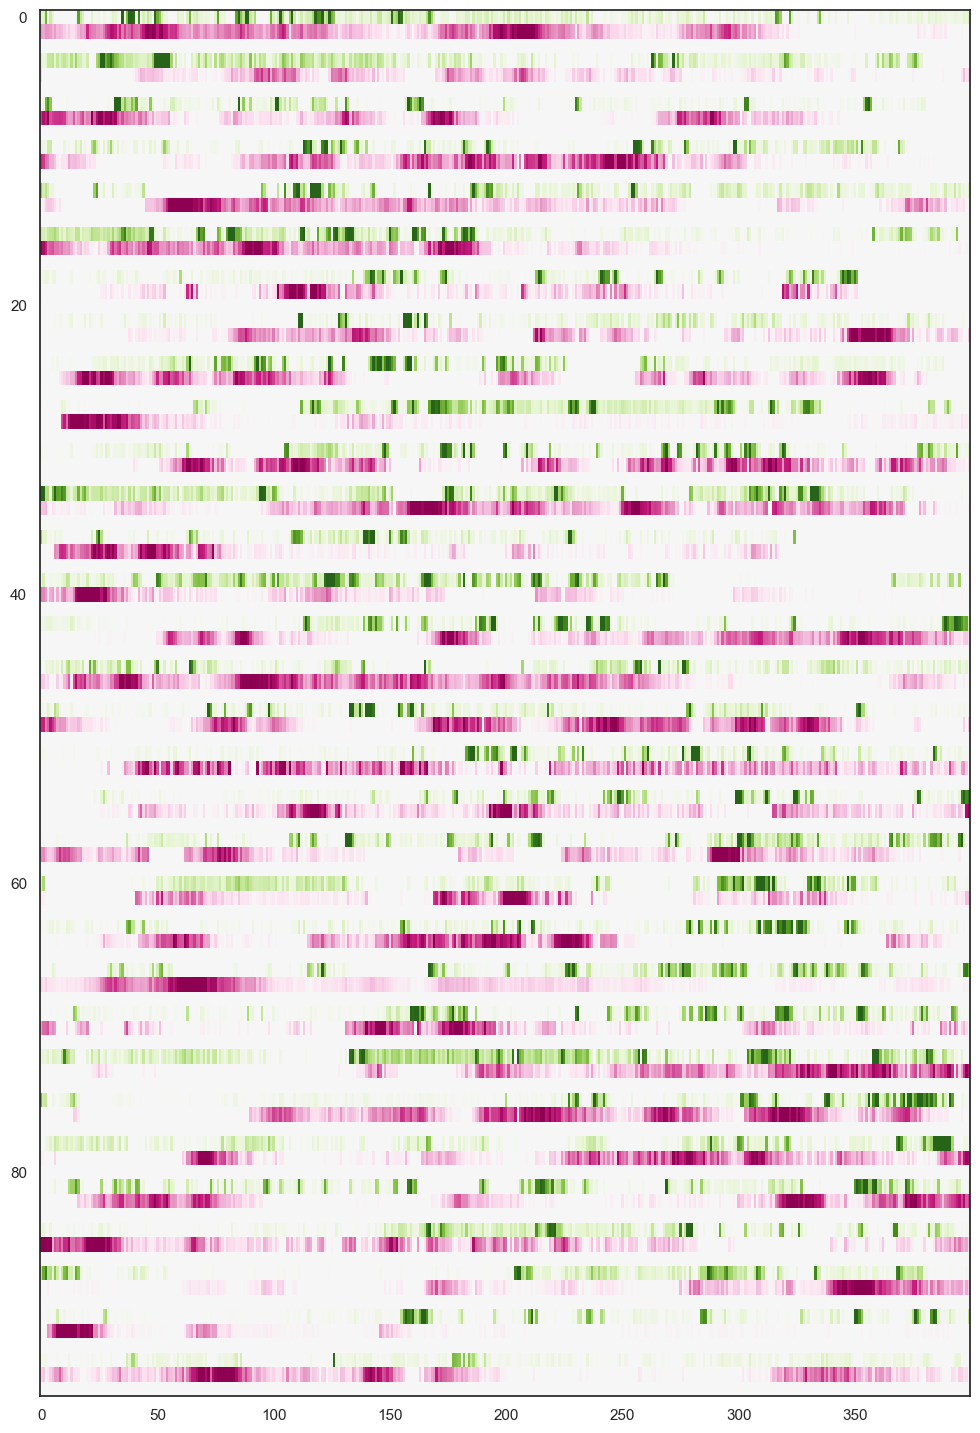

In [5]:
results = read_cond_traces(path_list[-3])
heatmap_arr = arrange_heatmap(results, 400, spacing=1)
plt.figure(figsize=(12, 18))
plt.imshow(heatmap_arr, aspect="auto", interpolation="nearest", cmap="PiYG")
plt.show()

In [118]:
def arrange_heatmap_clustered(results, sort_idx=None, max_length=0, spacing=0, ):
    if sort_idx is None:
        sort_idx = np.arange(len(results["G"]))
    G_df = [results["G"][i] for i in range(len(results["G"]))]
    R_df = [results["R"][i] for i in range(len(results["R"]))]
    heat_map_arr = np.ones((len(G_df) * (2+spacing), max_length)) * 0.5
    
    for j, (g_trace, r_trace, i) in enumerate(zip(G_df, R_df, sort_idx)):
        g_vals = g_trace["Normalized Intensity"][0:min(len(g_trace["t"]), max_length)]
        g_vals[g_vals < 0] = 0
        g_vals[g_vals > 1] = 1
        g_vals = g_vals / 2 + 0.5
        r_vals = r_trace["Normalized Intensity"][0:min(len(r_trace["t"]), max_length)]
        r_vals[r_vals < 0] = 0
        r_vals[r_vals > 1] = 1
        r_vals = 0.5 - r_vals / 2
        heat_map_arr[i * (2+spacing), 0:min(len(g_trace["t"]), max_length)] = r_vals
        heat_map_arr[i * (2+spacing) + 1, 0:min(len(r_trace["t"]), max_length) ] = g_vals
    return heat_map_arr

In [101]:
g_df = [results["G"][i]["Normalized Intensity"] for i in range(len(results["G"]))]
r_df = [results["R"][i]["Normalized Intensity"] for i in range(len(results["R"]))]
g_ts_df = [pd.DataFrame.from_dict(c22.catch22_all(ts)).set_index("names").transpose() for ts in g_df]
g_ts_df = pd.concat(g_ts_df).reset_index().drop(columns=["index"]).reset_index()
r_ts_df = [pd.DataFrame.from_dict(c22.catch22_all(ts)).set_index("names").transpose() for ts in r_df]
r_ts_df = pd.concat(r_ts_df).reset_index().drop(columns=["index"]).reset_index()
gr_df = g_ts_df.merge(r_ts_df, how="left", on="index", suffixes=("_G", "_R"), ).drop(columns=["index"])
gr_df

names,DN_HistogramMode_5_G,DN_HistogramMode_10_G,CO_f1ecac_G,CO_FirstMin_ac_G,CO_HistogramAMI_even_2_5_G,CO_trev_1_num_G,MD_hrv_classic_pnn40_G,SB_BinaryStats_mean_longstretch1_G,SB_TransitionMatrix_3ac_sumdiagcov_G,PD_PeriodicityWang_th0_01_G,...,FC_LocalSimple_mean1_tauresrat_R,DN_OutlierInclude_p_001_mdrmd_R,DN_OutlierInclude_n_001_mdrmd_R,SP_Summaries_welch_rect_area_5_1_R,SB_BinaryStats_diff_longstretch0_R,SB_MotifThree_quantile_hh_R,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1_R,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1_R,SP_Summaries_welch_rect_centroid_R,FC_LocalSimple_mean3_stderr_R
0,-0.746689,-0.472664,9.645995,11.0,0.258341,0.200701,0.888502,68.0,0.040000,11.0,...,0.010204,0.219130,-0.443478,0.877011,9.0,1.701484,0.152174,0.130435,0.030680,0.494554
1,-0.889183,-0.612318,4.858232,8.0,0.271327,0.157605,0.837413,34.0,0.104167,8.0,...,0.016949,0.830716,0.111693,0.934942,6.0,1.757658,0.195652,0.195652,0.042951,0.395109
2,-1.052748,-0.731608,2.267106,7.0,0.145240,0.047896,0.803136,27.0,0.012153,7.0,...,0.005525,-0.575652,0.506087,0.953614,8.0,1.693476,0.869565,0.869565,0.012272,0.326320
3,-0.139600,-0.537197,5.187642,21.0,0.131702,0.271243,0.728223,28.0,0.025510,32.0,...,0.011628,0.271304,-0.276522,0.946920,6.0,1.704350,0.586957,0.804348,0.049087,0.354422
4,-0.230759,-0.496582,2.359351,9.0,0.071470,0.242629,0.791289,16.0,0.003945,13.0,...,0.021277,-0.315217,-0.027174,0.832234,7.0,1.847387,0.304348,0.826087,0.067495,0.566931
5,-0.535470,-0.784504,3.170037,6.0,0.154485,0.358279,0.746241,15.0,0.080000,9.0,...,0.017241,-0.908068,0.221388,0.872923,6.0,1.915957,0.717391,0.652174,0.067495,0.488330
6,-0.866161,-0.625178,3.174307,5.0,0.189745,0.226057,0.724206,12.0,0.033531,9.0,...,0.005128,-0.738614,0.651485,0.979543,8.0,1.616247,0.652174,0.869565,0.024544,0.208282
7,0.085819,-0.279285,2.267321,5.0,0.063844,0.114604,0.768293,15.0,0.005301,6.0,...,0.010417,-0.941739,0.166087,0.964866,7.0,2.086548,0.630435,0.282609,0.085903,0.334881
8,-0.178743,-0.508724,2.758335,8.0,0.067775,-0.031477,0.792683,33.0,0.005208,11.0,...,0.015152,-0.481739,0.880000,0.856981,6.0,1.835966,0.847826,0.369565,0.055223,0.550180
9,-0.732874,-0.421853,2.924750,4.0,0.128602,0.267978,0.735192,16.0,0.012500,10.0,...,0.029412,-0.306087,0.784348,0.848519,6.0,1.932536,0.543478,0.434783,0.085903,0.563535


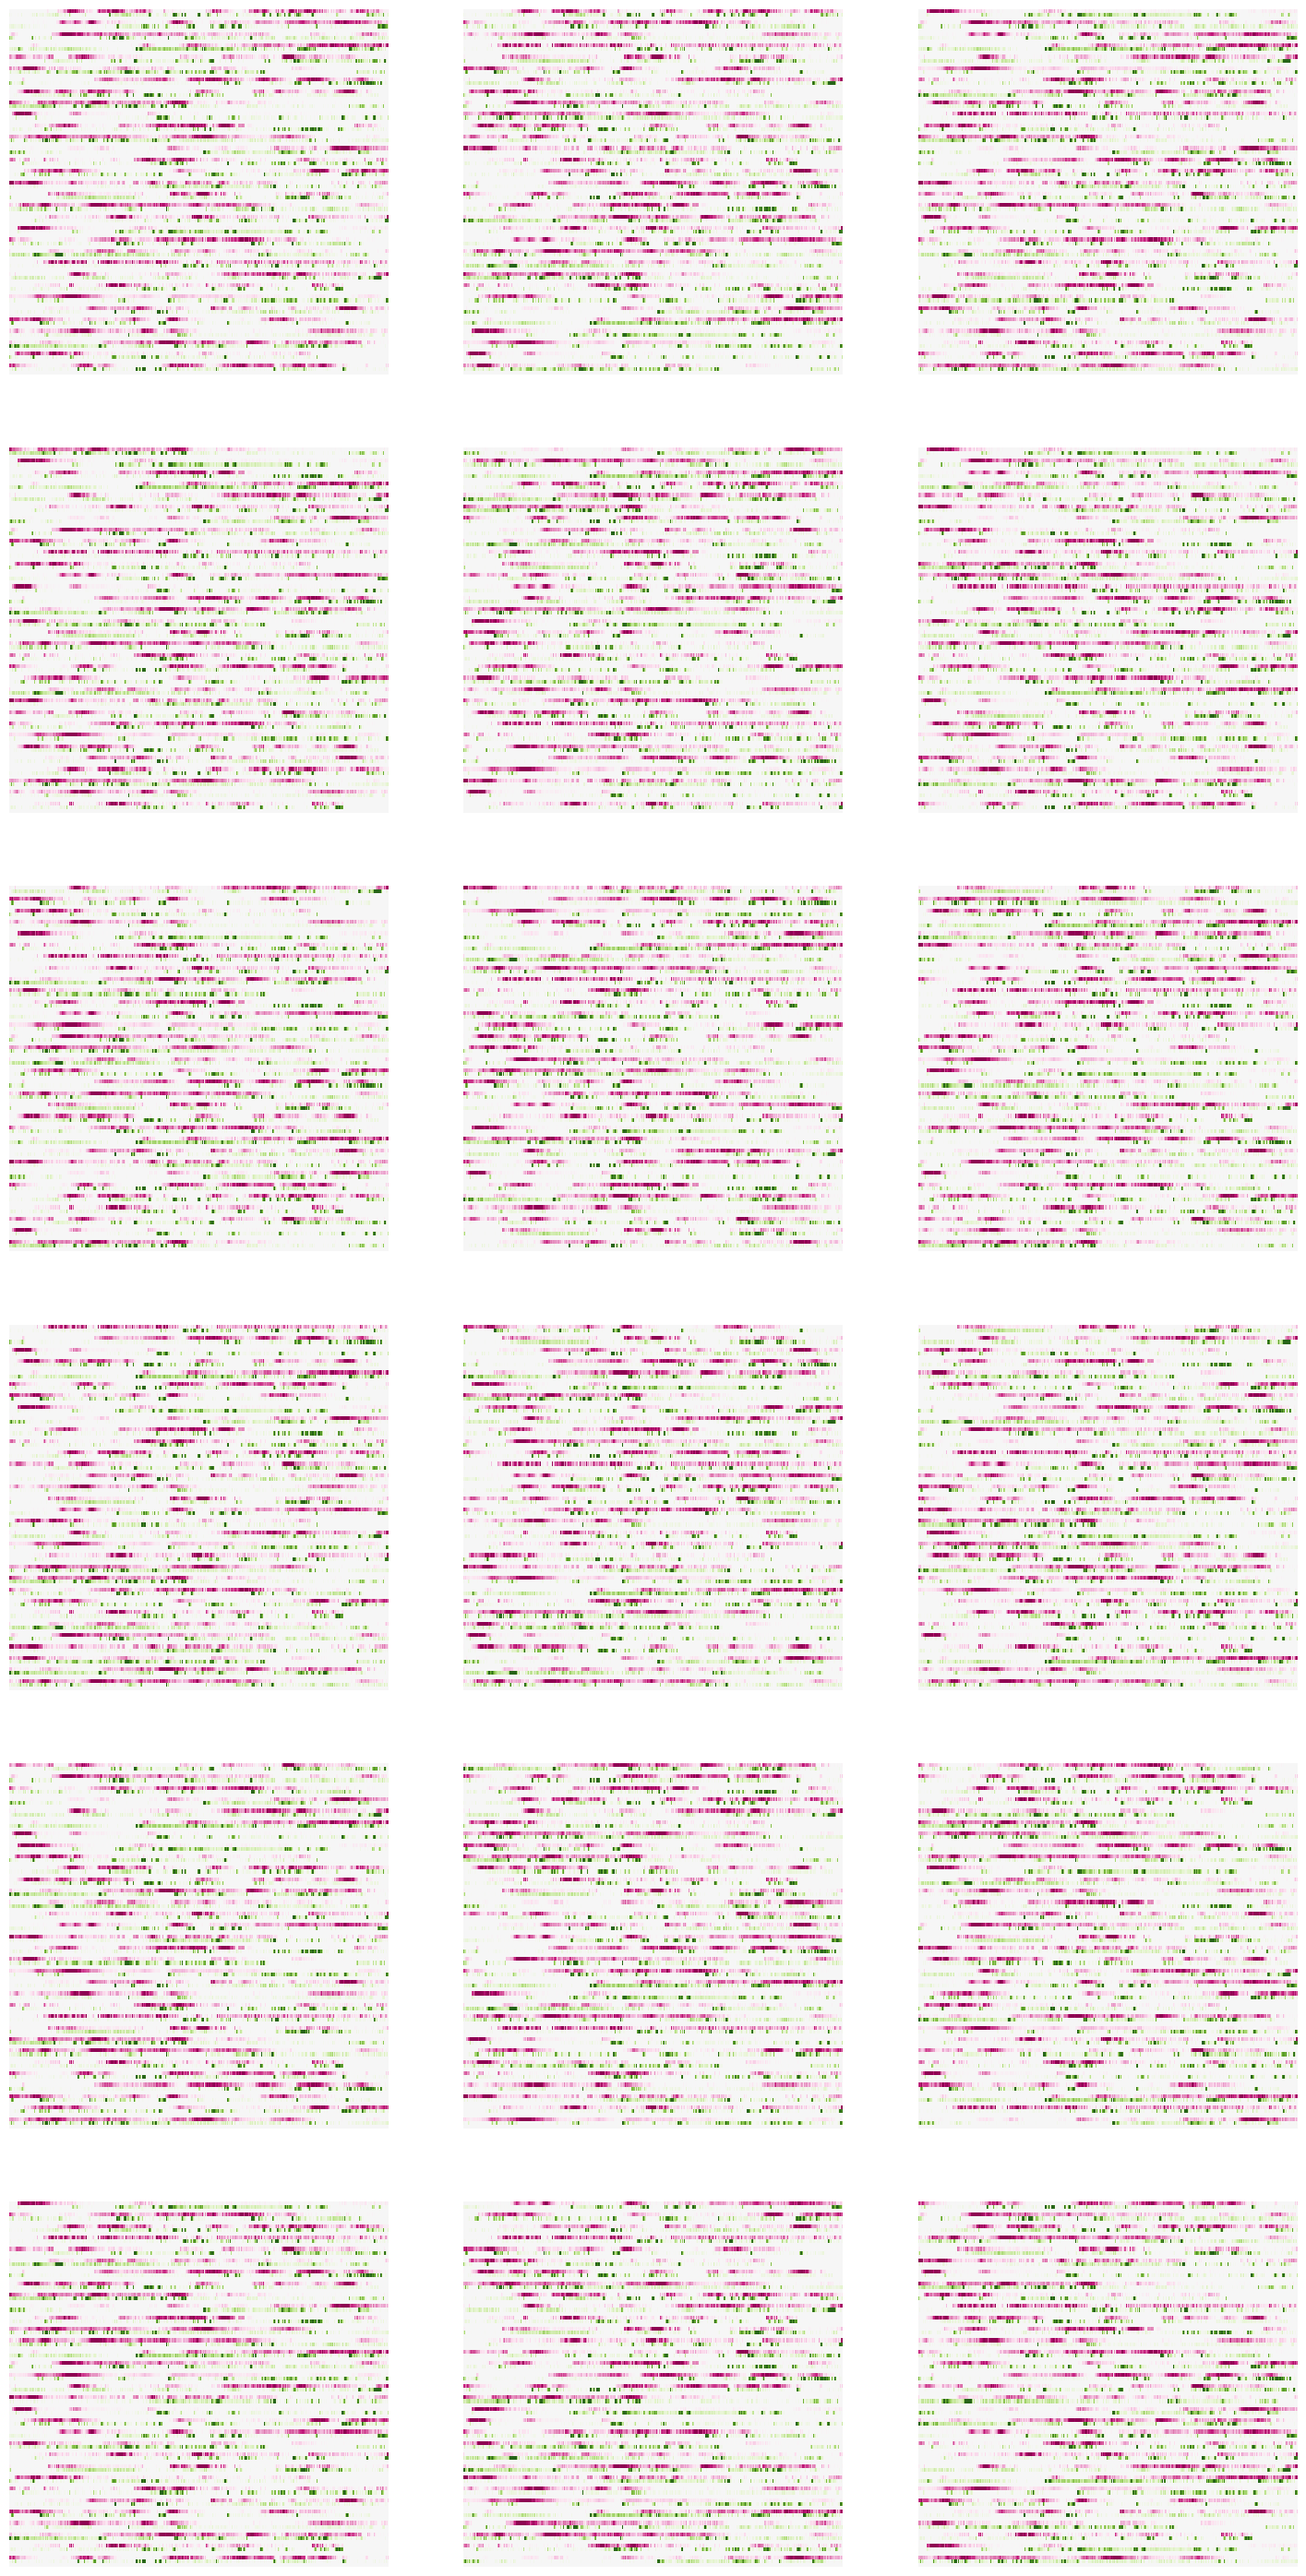

In [122]:
import umap
import umap.plot as uplt
neighbors = np.arange(4, 16, 2)
fig, ax = plt.subplots(nrows=len(neighbors), ncols=3, figsize=(18, len(neighbors) * 6))
for i, n_ in enumerate(neighbors):

    umapper = umap.UMAP(n_neighbors=n_, n_components=1)
    gr_mapper = umapper.fit(gr_df, )
    gr_transformed = umapper.fit_transform(gr_df)
    gr_sort_idx = np.argsort(gr_transformed.flatten())

    g_mapper = umapper.fit(g_ts_df, )
    g_transformed = umapper.fit_transform(g_ts_df)
    g_sort_idx = np.argsort(g_transformed.flatten())

    r_mapper = umapper.fit(r_ts_df, )
    r_transformed = umapper.fit_transform(r_ts_df)
    r_sort_idx = np.argsort(r_transformed.flatten())
    # uplt.points(mapper)
    heatmap_arr = arrange_heatmap_clustered(results,gr_sort_idx, 400, spacing=1)
    ax[i, 0].axis("off")
    ax[i, 0].imshow(heatmap_arr, aspect="auto", interpolation="nearest", cmap="PiYG")
    heatmap_arr = arrange_heatmap_clustered(results,g_sort_idx, 400, spacing=1)
    ax[i, 1].axis("off")
    ax[i, 1].imshow(heatmap_arr, aspect="auto", interpolation="nearest", cmap="PiYG")
    heatmap_arr = arrange_heatmap_clustered(results,r_sort_idx, 400, spacing=1)
    ax[i, 2].axis("off")
    ax[i, 2].imshow(heatmap_arr, aspect="auto", interpolation="nearest", cmap="PiYG")
plt.show()


In [123]:
results

{'G': [          x       y         I      t  spots  Normalized Intensity  Time (min)  \
  0    38.936  70.598  3304.596    2.0    0.0              0.124338    3.333333   
  1    38.936  70.598  3375.964    3.0    0.0              0.143100    5.000000   
  2    38.936  70.598  3379.368    4.0    0.0              0.143995    6.666667   
  3    38.936  70.598  3670.781    5.0    0.0              0.220606    8.333333   
  4    38.936  70.598  3206.840    6.0    0.0              0.098638   10.000000   
  ..      ...     ...       ...    ...    ...                   ...         ...   
  570  45.439  77.156  1876.762  572.0    0.0             -0.251032  953.333333   
  571  45.439  77.156  1522.561  573.0    0.0             -0.344150  955.000000   
  572  45.439  77.156  1508.502  574.0    0.0             -0.347846  956.666667   
  573  45.439  77.156  1880.919  575.0    0.0             -0.249939  958.333333   
  574  45.439  77.156  2275.806  576.0    0.0             -0.146126  960.000000   